# **Wrapper vs. Integration**

| Aspect               | **Wrapper**                             | **Integration**                         |
|----------------------|-----------------------------------------|-----------------------------------------|
| **Definition**       | Simplifies API interaction              | Embeds AI to extend functionality       |
| **Complexity**       | Minimal abstraction over the API        | Deep integration with application logic |
| **System Awareness** | Operate without context of the host system's state or data | Leverage system data (like database schemas) for context-aware responses |
| **Use Cases**        | Sending prompts, receiving responses    | Natural language commands, data import  |
| **Examples**         | PSOpenAI, finetuna, aitoolkit           | dbatools.ai, PSHelp.Copilot,<br/>Assistants Chat Extension for GitHub Copilot Chat |

### **Benefits of Integration**

- **Efficiency**: Saves time by automating complex tasks.
- **Accessibility**: Allows non-experts to perform advanced operations using plain language.
- **Intelligence**: Makes informed decisions based on system data.


Ultimately, AI integration is all about natural langauge. Both for the developers and the end-users.

# **Connecting to the OpenAI API using PowerShell**

Using the OpenAI API in PowerShell requires an API key from https://platform.openai.com/api-keys.

### Using PSOpenAI to connect to OpenAI

Straightforward request

In [ ]:
Request-ChatCompletion -Message "What is a splat?" | Select-Object -ExpandProperty Answer

Note the developer manually keeping track of the conversation history

In [ ]:
Request-ChatCompletion -Message "What is a splat?"

### Raw PowerShell behind the scenes

In [ ]:
# Set the headers
$headers = @{
    "Content-Type"  = "application/json"
    "Authorization" = "Bearer $env:OPENAI_API_KEY"
}

# Prepare the messages array
$msgs = @(
    @{
        role    = "user"
        content = "What is a splat?"
    }
)

# Create the splat for Invoke-RestMethod
$splat = @{
    Uri     = "https://api.openai.com/v1/chat/completions"
    Method  = "Post"
    Headers = $headers
    Body    = @{
        model    = "gpt-4o"
        messages = $msgs
    } | ConvertTo-Json
}

$response = Invoke-RestMethod @splat

# Output the assistant's reply
$response.choices[0].message.content

No history of the conversation by default

In [ ]:
$response

Let's set some default values

In [14]:
# Set default values
$PSDefaultParameterValues["Invoke-RestMethod:Headers"] = $headers
$PSDefaultParameterValues["Invoke-RestMethod:Method"] = "POST"
$PSDefaultParameterValues["Invoke-RestMethod:Uri"] = "https://api.openai.com/v1/chat/completions"
$PSDefaultParameterValues["*:OutVariable"] = "outvar"

### But what about PowerShell Splats? Let's narrow the response context

In [ ]:
# Prepare the messages array
$msgs = @(
    @{
        role    = "system"
        content = "You are a PowerShell Expert."
    }
    @{
        role    = "user"
        content = "What is a splat?"
    }
)

# Prepare the body
$body = @{
    model    = "gpt-4o"
    messages = $msgs
} | ConvertTo-Json

$response = Invoke-RestMethod -Body $body

# Output the assistant's reply
$response.choices[0].message.content

### Btw, how do I know which models I can use?

In [ ]:
(Invoke-RestMethod -Method Get -Uri https://api.openai.com/v1/models).data.id

### Now save that like a script or a module or... an assistant.

Assistants are cool because they:

* Remember the conversation history
* Can be shared with others
* Can upload files and use them as context
* Are all around more powerful than chat completions

**Create an Assistant**

In [ ]:

$splat = @{
    Name         = "Chrissy LeMaire"
    Model        = "gpt-4o"
    Instructions = 'You are PowerShell expert and dbatools creator Chrissy LeMaire. You ❤️ splats with $splat and @splat. USE A LOT OF EMOJIS PLZ'
}
New-Assistant @splat

**Create a conversation**

In [ ]:
$assistant = Get-Assistant -All | Select-Object -Last 1

# Create whole thread (to keep track of convos)
$run = New-Thread |
       Add-ThreadMessage -Message "What is a splat in PowerShell?" -PassThru |
       Start-ThreadRun -Assistant $assistant |
       Receive-ThreadRun -Wait

# Display the Assistant's Response
$run.Messages.SimpleContent.Content | Select -Last 1

### Adding attachments/images

In [ ]:
#Upload images for references
$image1 = Add-OpenAIFile -File lib/copilot.example.png -Purpose vision
$image2 = Add-OpenAIFile -File lib/immunization.png -Purpose vision

# Create a Thread and add a message with images.
$results = New-Thread |
Add-ThreadMessage "Which one is PowerShell code?" -Images $image1, $image2 -PassThru |
Start-ThreadRun -Assistant $Assistant |
Receive-ThreadRun -Wait

($results.Messages.SimpleContent | Select -Last 1).Content

## The magic 🧙

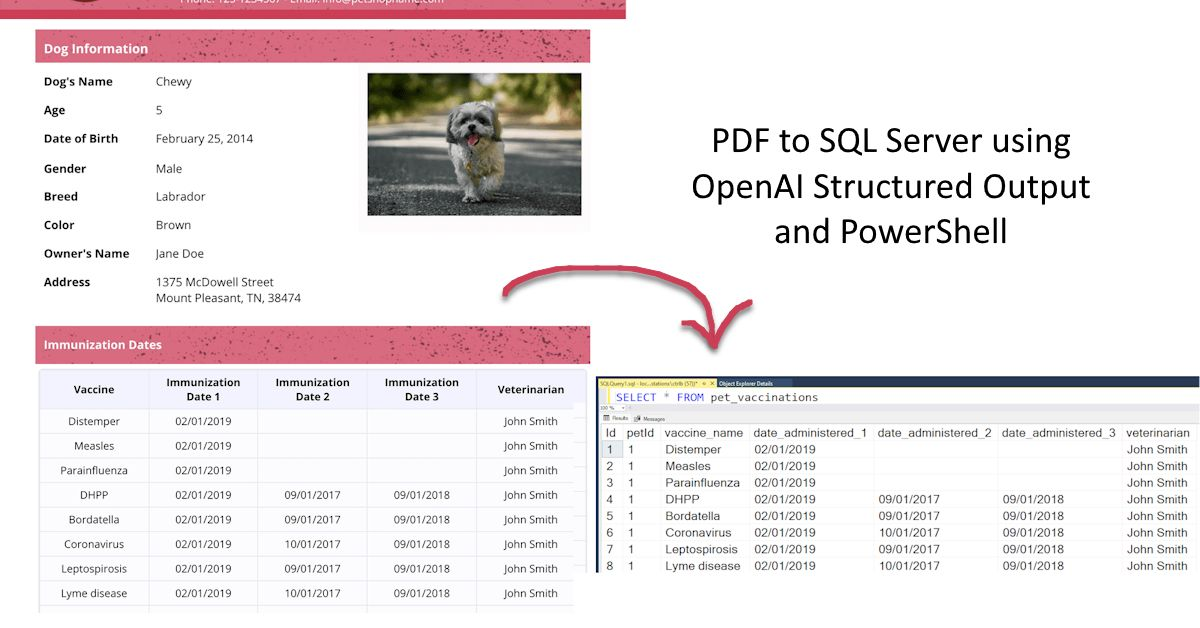

### dbatools.ai has an example command, Import-DbaiFile, that shows you how to do this

In [ ]:
Import-Module ./dbatools.ai.psd1 -Force

$splat = @{
    Path            = './lib/immunization.md'
    JsonSchemaPath  = './lib/immunization.json'
    SqlInstance     = 'localhost'
    Database        = 'tempdb'
    Schema          = 'dbo'
    SystemMessage   = 'Convert text to structured data.'
}

Import-DbaiFile @splat

### See the output!

In [ ]:
Invoke-DbaQuery -SqlInstance localhost -Query "SELECT * FROM tempdb.dbo.pet_vaccinations"

## Structured Output's JSON in-depth

In [ ]:
# Define the JSON schema as a PowerShell object
# You can use ChatGPT for this part, I do
$schema = @{
    name   = "cultural_comparison_schema"
    strict = $true
    schema = @{
        type       = "object"
        properties = @{
            country = @{
                type = "string"
                enum = @("USA", "Belgium", "Germany")
                description = "Is the topic more American, Belgian or German?"
            }
            reasoning = @{
                type        = "string"
                description = "What is the reasoning behind this conclusion?"
            }
        }
        required            = @("country", "reasoning")
        additionalProperties = $false
    }
}

# Convert the PowerShell object to JSON
$json = $schema | ConvertTo-Json -Depth 5

# Splat parameters for Request-ChatCompletion
$splat = @{
    Model      = "gpt-4o-mini"
    Message    = "Is beer more American, Belgian or German?"
    Format     = "json_schema"
    JsonSchema = $json
}

# Make the request and output to console
((Request-ChatCompletion @splat).Answer | ConvertFrom-Json).reasoning

### Kinda like PowerShell params? But it's output and not input.
    
```powershell
[Parameter(Mandatory)]
[ValidateSet("USA", "Belgium", "Germany")]
[string]$country
```

Let's look at this in a fun command

In [ ]:
function Compare-CountryCulture {
<#
    .SYNOPSIS
    Determines if a topic is more American, Belgian or German using AI.

    .DESCRIPTION
    Uses an AI model to determine whether a given topic is more associated with the USA or Belgium and provides the reasoning.

    .PARAMETER Topic
    The topic to be analyzed.

    .PARAMETER Model
    The name of the AI model to use. Default is 'gpt-4o-mini'.

    .EXAMPLE
    PS C:\> Compare-CountryCulture -Topic "beer"
#>
    [CmdletBinding()]
    param(
        [Parameter(Mandatory, ValueFromPipeline, ValueFromRemainingArguments, Position = 0)]
        [string]$Topic,
        [string]$Model = 'gpt-4o-mini'
    )
    begin {
        # Define the JSON schema as a PowerShell object
        $schema = @{
            name   = "cultural_comparison_schema"
            strict = $true
            schema = @{
                type       = "object"
                properties = @{
                    country = @{
                        type = "string"
                        enum = @("USA", "Belgium", "Germany")
                        description = "Is the topic more American, Belgian or German?"
                    }
                    reasoning = @{
                        type        = "string"
                        description = "What is the reasoning behind this conclusion?"
                    }
                }
                required            = @("country", "reasoning")
                additionalProperties = $false
            }
        }

        # Convert the PowerShell object to JSON
        $json = $schema | ConvertTo-Json -Depth 5
    }

    process {
        # Splat parameters for Request-ChatCompletion
        $splat = @{
            Model      = $Model
            Message    = $Topic
            Format     = "json_schema"
            JsonSchema = $json
        }

        # Make the request and output to console
        $result = Request-ChatCompletion @splat
        $parsedResult = $result.Answer | ConvertFrom-Json

        [PSCustomObject]@{
            Topic     = $Topic
            Country   = $parsedResult.country
            Reasoning = $parsedResult.reasoning
        } | Format-List *
    }
}
Compare-CountryCulture beer
Compare-CountryCulture food
Compare-CountryCulture healthcare
Compare-CountryCulture olympics
Compare-CountryCulture artificial intelligence

# dbatools.ai overview

This module creates copilots for SQL Server databases and dbatools commands. Oh, and imports files into databases.

### **Import-DbaiFile**
Imports structured file content into a database, using AI and predefined schemas for processing.

| Step                  | Description                                                                                              |
|-----------------------|----------------------------------------------------------------------------------------------------------|
| **Input Handling**    | Accepts file paths and predefined JSON schemas for processing.                                           |
| **Schema Parsing**    | Uses the schema to validate and convert file content into structured data.                               |
| **Data Import**       | Converts the file content into database commands and imports it into the specified database. |

### **New-DbaiAssistant**
Creates an AI assistant to interpret natural language commands for database tasks.

| Step                 | Description                                                                                              |
|----------------------|----------------------------------------------------------------------------------------------------------|
| **Initialization**   | Creates an AI assistant with a specified name and instructions.                                          |
| **Configuration**    | Sets context and schema to interpret future queries.                                                     |
| **Caching**          | Caches the assistant for reuse in future commands.                                                       |

In [ ]:
Get-DbaDatabase -SqlInstance localhost -Database Northwind | New-DbaiAssistant

### **Invoke-DbaiQuery**
Converts natural language into SQL queries, referencing the database schema for accuracy.

| Step                    | Description                                                                                             |
|-------------------------|---------------------------------------------------------------------------------------------------------|
| **Input Handling**      | Accepts a natural language query related to database operations.                                        |
| **AI Processing**       | Uses an AI assistant to interpret input and generate an SQL (T-SQL) query.                              |
| **Schema Consultation** | References database schema (tables, columns) for constructing the query accurately.                     |

In [ ]:
Invoke-DbaiQuery Any employee birthdays coming up? It is Oct 3

### **Invoke-DbatoolsAI**
Translates natural language input into `dbatools` commands, focusing on operations like `Copy-DbaDatabase`.

| Step                   | Description                                                                                              |
|------------------------|----------------------------------------------------------------------------------------------------------|
| **Assistant Setup**    | Checks for an existing assistant or creates one using cached instructions.                              |
| **Message Processing** | Processes natural language input and sends it to the assistant for interpretation.                      |
| **Command Execution**  | Converts input into a `dbatools` command.                                                               |

In [26]:
Invoke-DbatoolsAI Copy the SalesDB database from sql01 to sql02 using the network share \\NetworkPath